# Health Insurance Predictor

## 1. Loading Libraries & Importing Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor

In [2]:
!pip install xgboost

In [3]:
df = pd.read_excel('premiums_rest.xlsx')

In [4]:
df.shape

(29904, 14)

In [5]:
df.head()

,Unnamed: 0,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,5,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


## 2. Data Cleaning & EDA

In [6]:
df.columns

Index(['Unnamed: 0', 'Age', 'Gender', 'Region', 'Marital_status',
       'Number Of Dependants', 'BMI_Category', 'Smoking_Status',
       'Employment_Status', 'Income_Level', 'Income_Lakhs', 'Medical History',
       'Insurance_Plan', 'Annual_Premium_Amount'],
      dtype='object')

In [7]:
# Standardizing column names

df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head()

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,5,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29904 entries, 0 to 29903
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   unnamed:_0             29904 non-null  int64 
 1   age                    29904 non-null  int64 
 2   gender                 29904 non-null  object
 3   region                 29904 non-null  object
 4   marital_status         29904 non-null  object
 5   number_of_dependants   29904 non-null  int64 
 6   bmi_category           29904 non-null  object
 7   smoking_status         29895 non-null  object
 8   employment_status      29903 non-null  object
 9   income_level           29895 non-null  object
 10  income_lakhs           29904 non-null  int64 
 11  medical_history        29904 non-null  object
 12  insurance_plan         29904 non-null  object
 13  annual_premium_amount  29904 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 3.2+ MB


### Handling Missing & Duplicate Values

In [9]:
df.isna().sum()

unnamed:_0               0
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

* Since, the number of null values are less, we will proceed in dropping those records.

In [10]:
df.dropna(inplace=True)
df.isna().sum()

unnamed:_0               0
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [11]:
df.duplicated().sum()

np.int64(0)

In [12]:
df.describe()

,unnamed:_0,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000,29886.000000
mean,25027.094091,43.396105,2.379910,23.364184,20892.303821
std,14432.632929,13.412657,1.431201,24.740339,6936.813440
min,0.000000,26.000000,-3.000000,1.000000,3625.000000
25%,12599.250000,34.000000,1.000000,7.000000,15697.250000
50%,25067.500000,42.000000,3.000000,17.000000,20489.000000
75%,37563.750000,52.000000,3.000000,32.000000,26360.000000
max,49999.000000,356.000000,5.000000,930.000000,43471.000000


In [13]:
df[df['number_of_dependants'] < 0]['number_of_dependants'].unique()

array([-1, -3])

* Since, the number of dependants cannot be negative, we will convert those values into positive numbers.

In [14]:
df['number_of_dependants'] = df['number_of_dependants'].abs()

In [15]:
df.describe()

,unnamed:_0,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000,29886.000000
mean,25027.094091,43.396105,2.385933,23.364184,20892.303821
std,14432.632929,13.412657,1.421137,24.740339,6936.813440
min,0.000000,26.000000,0.000000,1.000000,3625.000000
25%,12599.250000,34.000000,1.000000,7.000000,15697.250000
50%,25067.500000,42.000000,3.000000,17.000000,20489.000000
75%,37563.750000,52.000000,3.000000,32.000000,26360.000000
max,49999.000000,356.000000,5.000000,930.000000,43471.000000


### Univariate Analysis of Numeric Columns

In [16]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns

Index(['unnamed:_0', 'age', 'number_of_dependants', 'income_lakhs',
       'annual_premium_amount'],
      dtype='object')

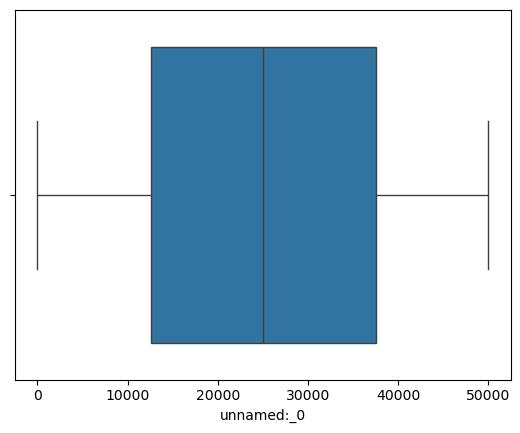

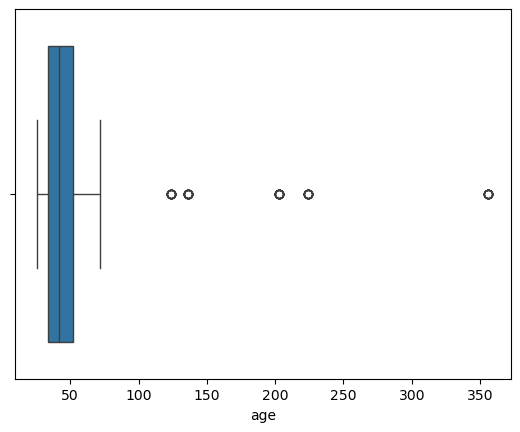

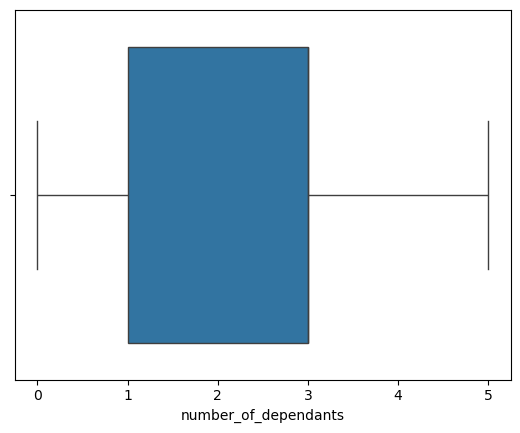

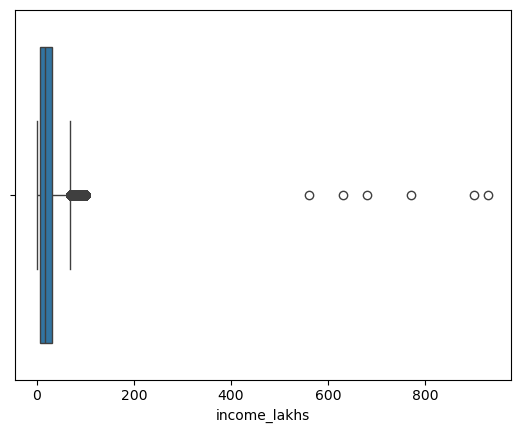

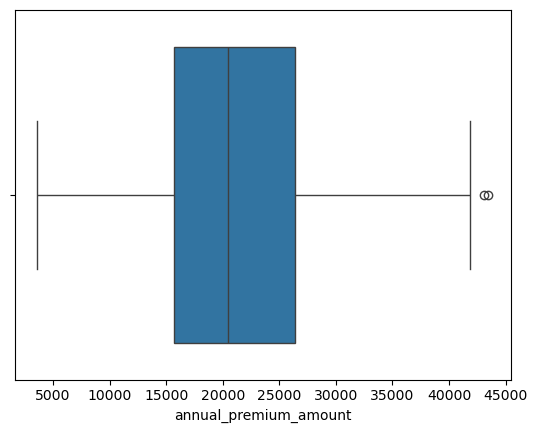

In [17]:
# Visualizing distribution of each columns using box plot

for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

### Treating Outliers

In [18]:
df[df['age'] > 100]['age'].unique()

array([224, 124, 136, 203, 356])

In [19]:
df1 = df[df['age'] <= 100]

In [20]:
df1.age.describe()

count    29828.000000
mean        43.095380
std         11.041991
min         26.000000
25%         34.000000
50%         42.000000
75%         52.000000
max         72.000000
Name: age, dtype: float64

In [21]:
# Handling outiers in income_lakhs column

def get_iqr_bound(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    return lower, upper

lower, upper = get_iqr_bound(df1['income_lakhs'])
lower, upper

(-30.5, 69.5)

In [22]:
df1[df1['income_lakhs'] > upper].shape

(2090, 14)

* Since, these records appears to be legitimate, we can't remove it using IQR records. We will try using simple quantile method.

In [23]:
quantile_threshold = df1['income_lakhs'].quantile(0.999)
print(quantile_threshold)

100.0


In [24]:
df1[df1['income_lakhs'] > quantile_threshold].shape

(6, 14)

* Since, there are only few records, we will remove it from our dataset.

In [25]:
df2 = df1[df1['income_lakhs'] <= quantile_threshold]
df2.shape

(29822, 14)

IndexError: index 2 is out of bounds for axis 0 with size 2

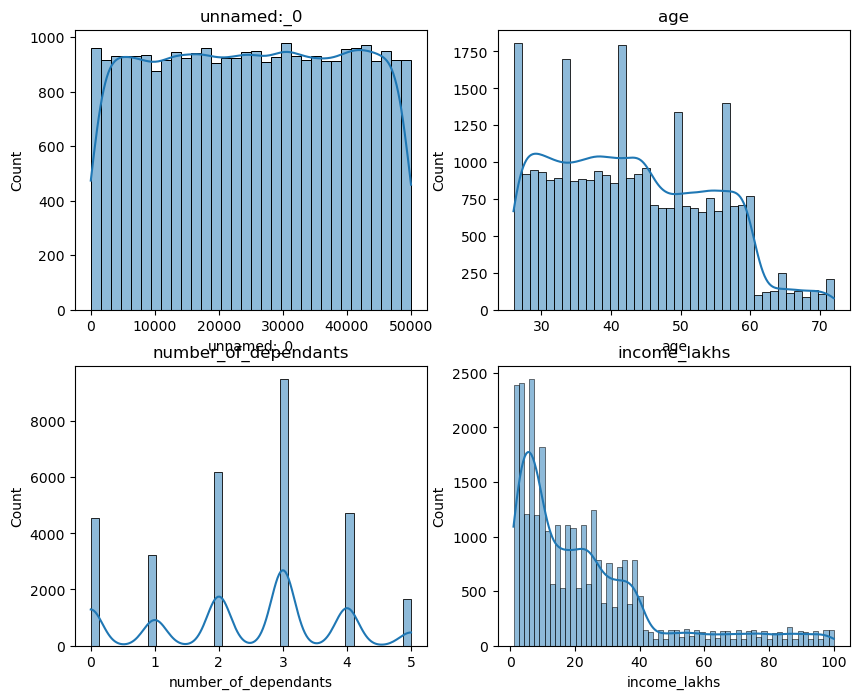

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))  # Adjust the size as necessary

for i, column in enumerate(numeric_columns):
    ax = axs[i//2, i%2]  # Determines the position of the subplot in the grid
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

In [27]:
df2.head(3)

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


### Bivariate Analysis

In [28]:
numeric_columns

Index(['unnamed:_0', 'age', 'number_of_dependants', 'income_lakhs',
       'annual_premium_amount'],
      dtype='object')

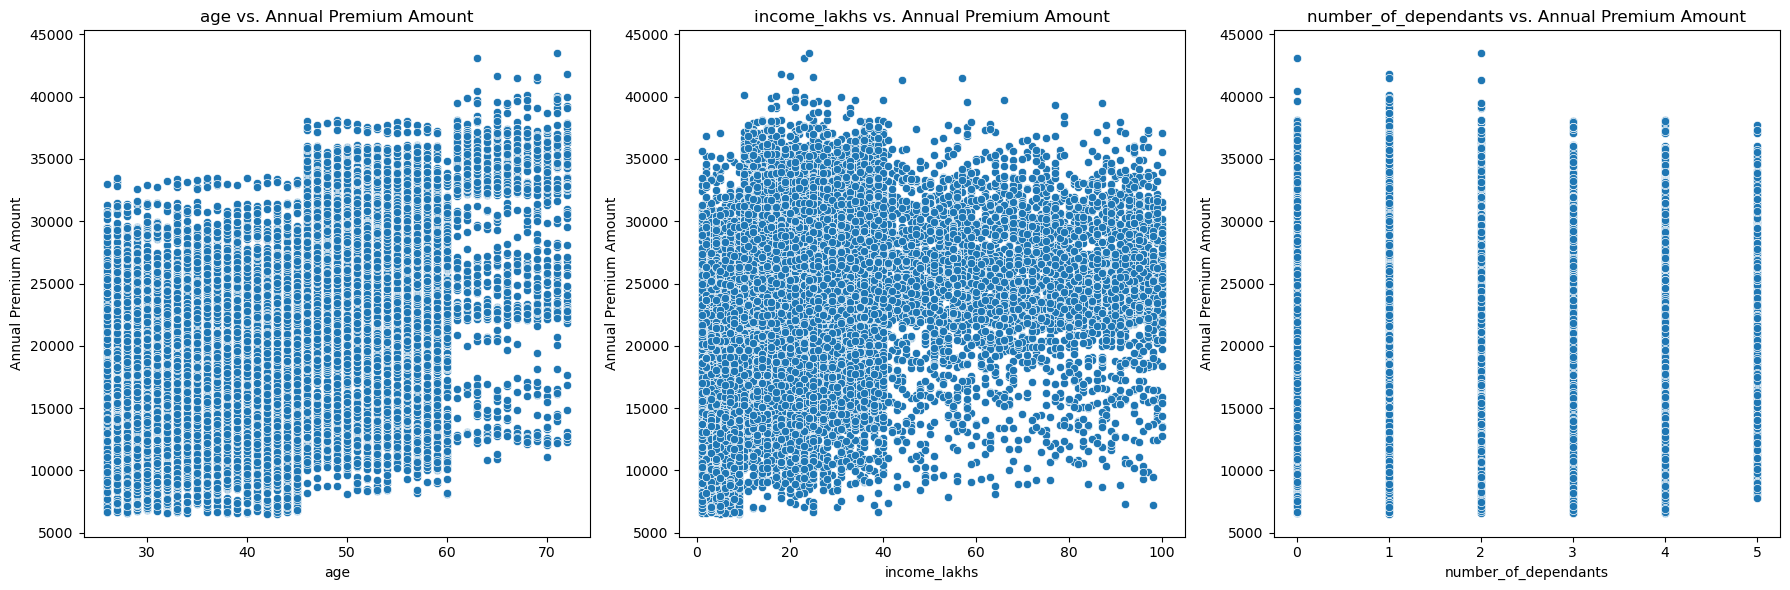

In [29]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

### Analyzing Categorical Columns

In [30]:
df2.head(1)

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053


In [31]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
categorical_cols

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status',
 'income_level',
 'medical_history',
 'insurance_plan']

In [32]:
for col in categorical_cols:
    print(col, ':', df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [33]:
# Handling data inconsistencies

df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Not Smoking': 'No Smoking'
}, inplace=True)

df2['smoking_status'].unique()

C:\Users\win10\AppData\Local\Temp\ipykernel_2512\2115574736.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({
C:\Users\win10\AppData\Local\Temp\ipykernel_2512\2115574736.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['smoking_status'].replace({


array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

### Univariate Analysis of Categorical Columns

In [34]:
# Analyzing distribution of gender

pct_count = df2['gender'].value_counts(normalize=True)*100
pct_count

gender
Male      54.912481
Female    45.087519
Name: proportion, dtype: float64

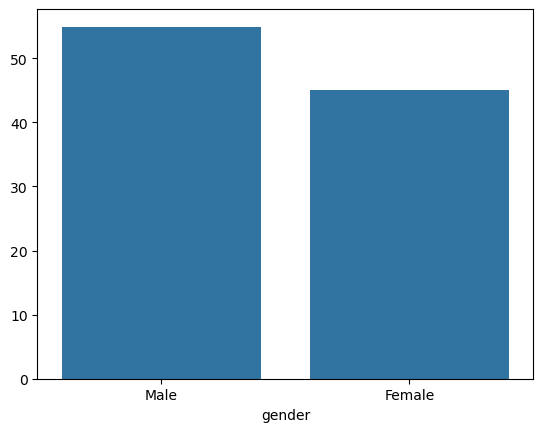

In [35]:
sns.barplot(x=pct_count.index, y=pct_count.values)
plt.show()

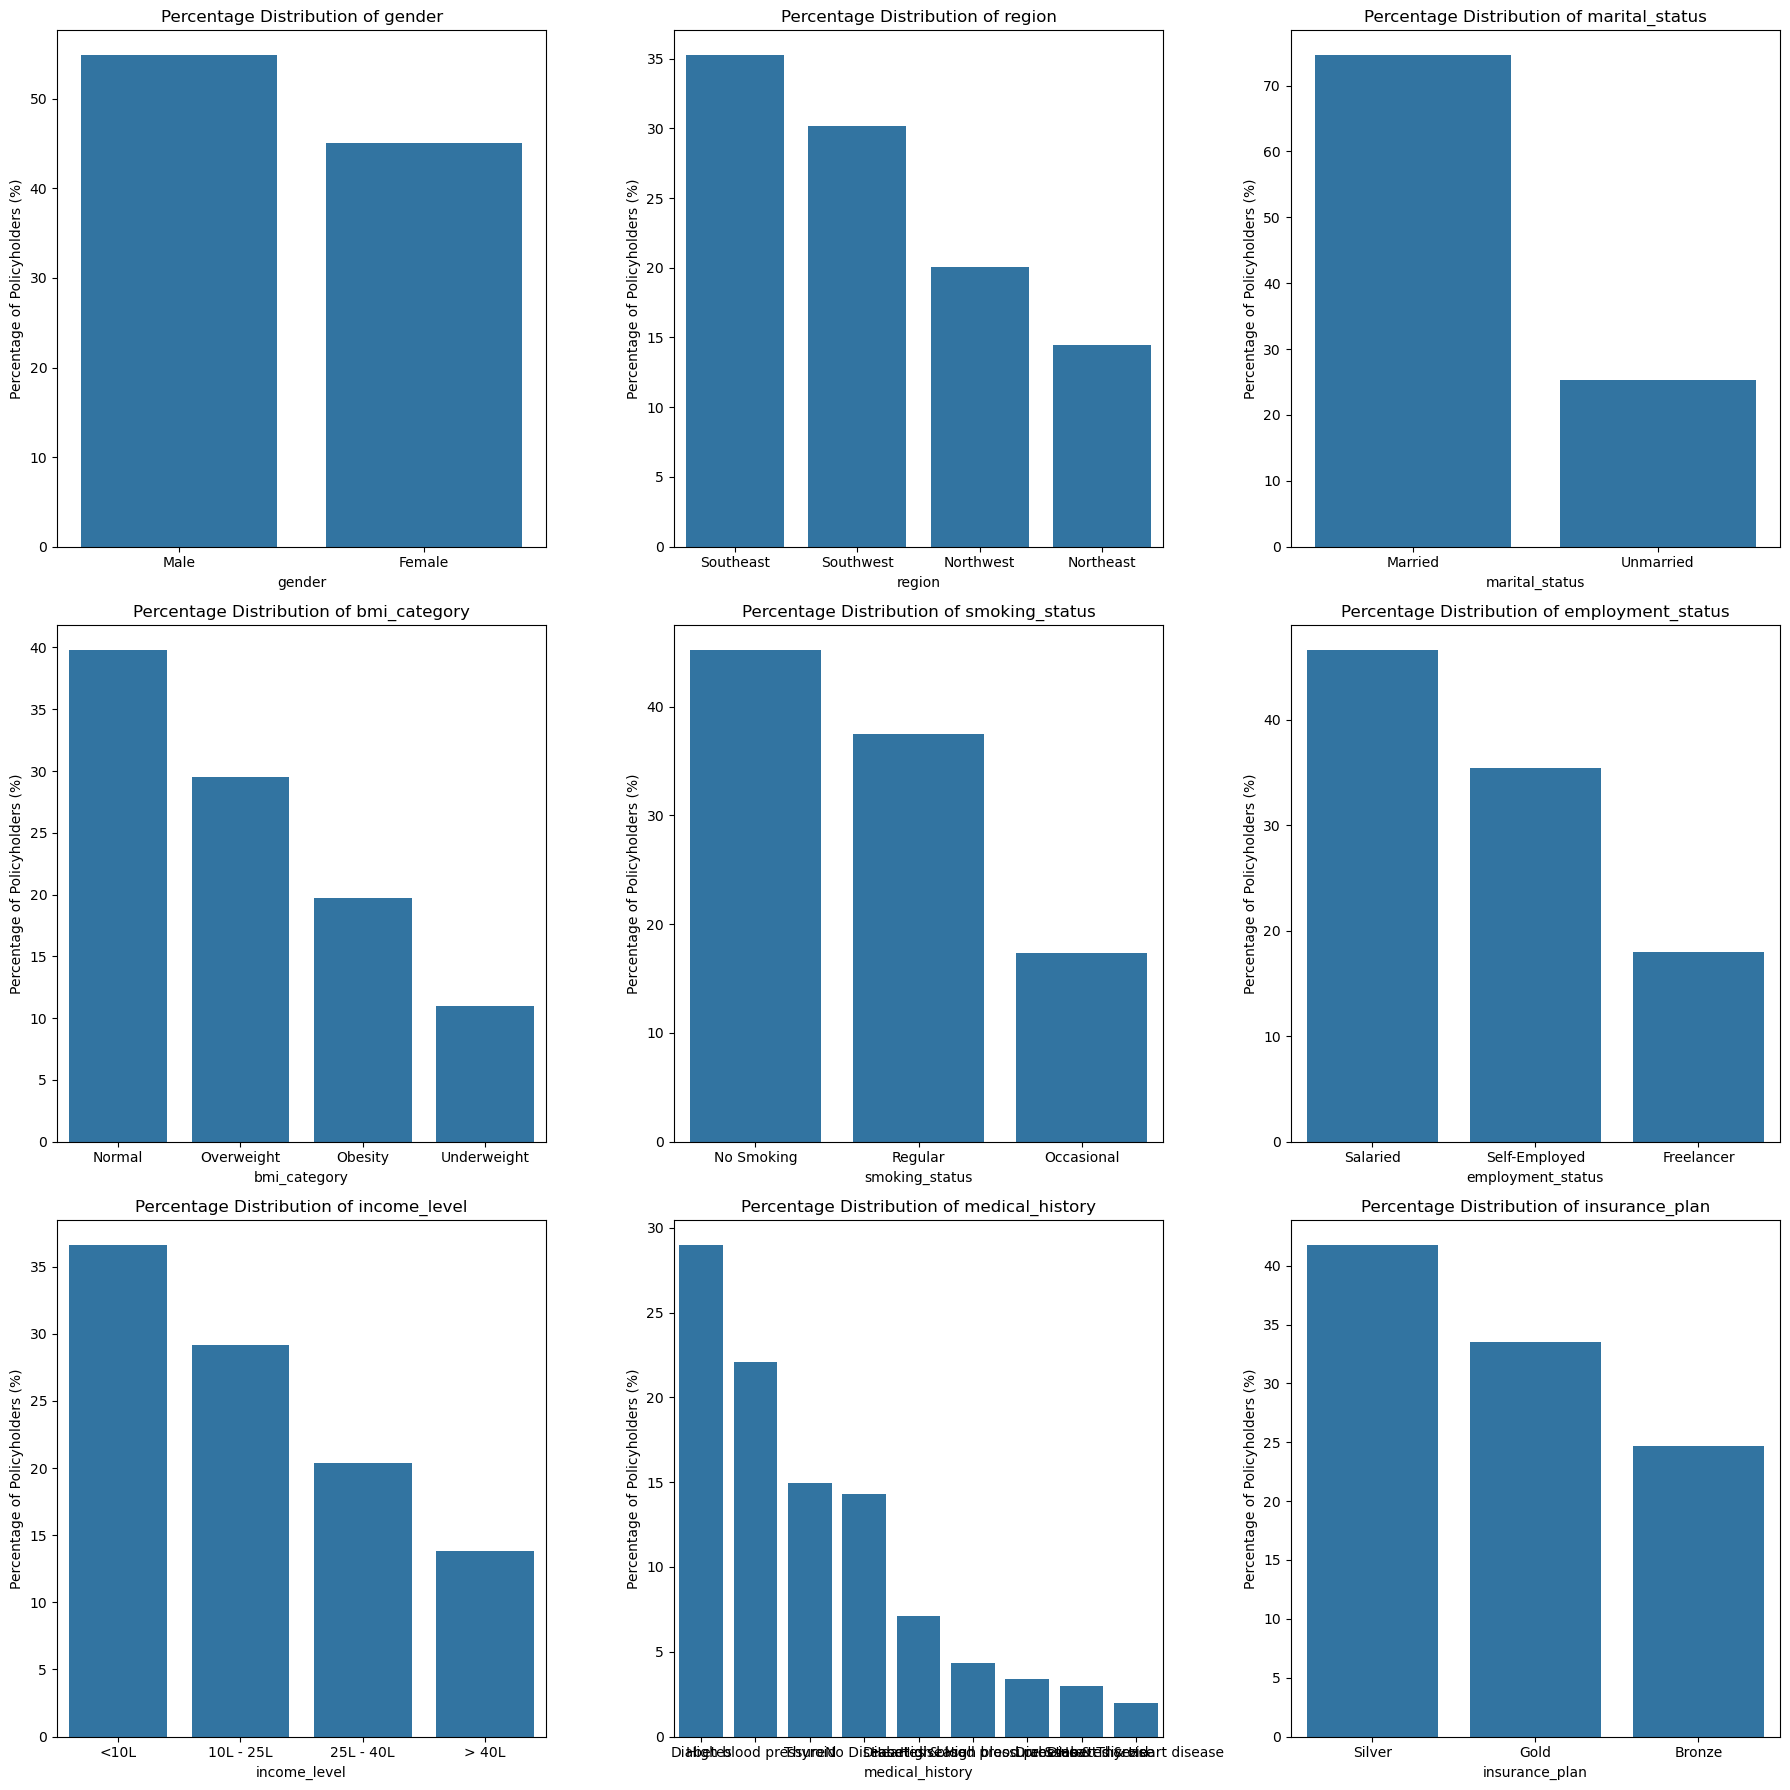

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

### Bivariate Analysis of Categorical Columns

In [37]:
# Cross tabulation of income level and insurance plan
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          799  3554    4354
25L - 40L          301  2631    3142
<10L              6054   527    4341
> 40L              214  3287     618


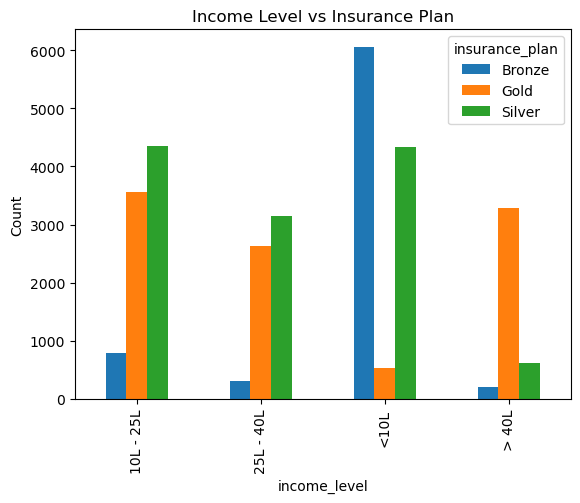

In [38]:
# Plotting crosstab
crosstab.plot(kind='bar')
plt.title('Income Level vs Insurance Plan')
plt.ylabel('Count')
plt.show()

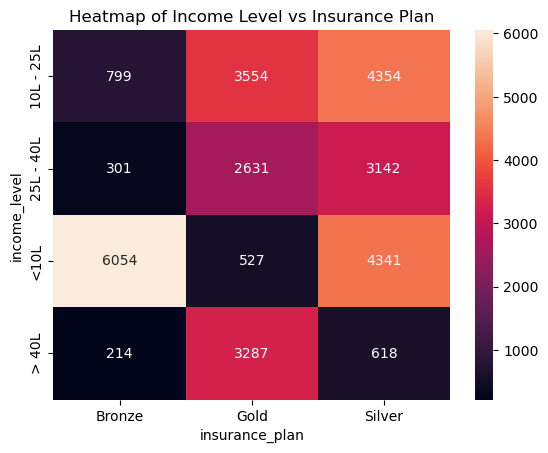

In [39]:
sns.heatmap(crosstab, annot=True, fmt='d')
plt.title('Heatmap of Income Level vs Insurance Plan')
plt.show()

## 3. Feature Engineering

In [40]:
df2.head(2)

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


### Calculating Risk Scores

In [41]:
df2['medical_history'].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [42]:
risk_scores = {
    'diabetes': 6,
    'heart disease': 8,
    'high blood pressure': 6,
    'thyroid': 5,
    'no disease': 0,
    'none': 0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(' & ', expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

C:\Users\win10\AppData\Local\Temp\ipykernel_2512\1568185411.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[['disease1', 'disease2']] = df2['medical_history'].str.split(' & ', expand=True).apply(lambda x: x.str.lower())
C:\Users\win10\AppData\Local\Temp\ipykernel_2512\1568185411.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[['disease1', 'disease2']] = df2['medical_history'].str.split(' & ', expand=True).apply(lambda x: x.str.lower())
C:\Users\win10\AppData\Local\Temp\ipykernel_2512\15681

In [43]:
df2.head()

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,0
1,1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,0
2,2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,0
3,3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0
4,5,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,diabetes,none,0


In [44]:
for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

df2.head()

C:\Users\win10\AppData\Local\Temp\ipykernel_2512\1880873791.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['total_risk_score'] += df2[disease].map(risk_scores)
C:\Users\win10\AppData\Local\Temp\ipykernel_2512\1880873791.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['total_risk_score'] += df2[disease].map(risk_scores)


,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6
1,1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6
2,2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6
3,3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0
4,5,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,diabetes,none,6


In [45]:
# Normalizing risk scores

min_score = df2['total_risk_score'].min()
max_score = df2['total_risk_score'].max()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score)/(max_score - min_score)
df2.head(3)

C:\Users\win10\AppData\Local\Temp\ipykernel_2512\163394873.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score)/(max_score - min_score)


,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571


### Encoding Text Columns

In [46]:
df2['insurance_plan'].unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [47]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

C:\Users\win10\AppData\Local\Temp\ipykernel_2512\2544073899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})


In [48]:
df2['income_level'].unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [49]:
df2['income_level'] = df2['income_level'].map({'<10L': 1, '10L - 25L': 2, '25L - 40L': 3, '> 40L': 4})

C:\Users\win10\AppData\Local\Temp\ipykernel_2512\1698088322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['income_level'] = df2['income_level'].map({'<10L': 1, '10L - 25L': 2, '25L - 40L': 3, '> 40L': 4})


In [50]:
df2.head()

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,no disease,none,0,0.000000
4,5,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,2,14,Diabetes,1,15610,diabetes,none,6,0.428571


In [51]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',  'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(4)

,unnamed:_0,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0,26,0,1,6,Diabetes,1,9053,diabetes,none,...,0,0,1,0,0,0,0,0,1,0
1,1,29,2,1,6,Diabetes,1,16339,diabetes,none,...,1,0,0,1,0,0,0,1,1,0
2,2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,...,0,0,0,0,0,0,0,0,0,1
3,3,30,3,4,77,No Disease,3,20303,no disease,none,...,1,0,0,0,0,0,0,0,1,0


In [52]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29822 entries, 0 to 29903
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   unnamed:_0                       29822 non-null  int64  
 1   age                              29822 non-null  int64  
 2   number_of_dependants             29822 non-null  int64  
 3   income_level                     29822 non-null  int64  
 4   income_lakhs                     29822 non-null  int64  
 5   medical_history                  29822 non-null  object 
 6   insurance_plan                   29822 non-null  int64  
 7   annual_premium_amount            29822 non-null  int64  
 8   disease1                         29822 non-null  object 
 9   disease2                         29822 non-null  object 
 10  total_risk_score                 29822 non-null  int64  
 11  normalized_risk_score            29822 non-null  float64
 12  gender_Male            

### Feature Selection

In [53]:
df4 = df3.drop(['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(2)

,unnamed:_0,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0


In [54]:
# Calculating VIF for multicollinearity

df4.columns

Index(['unnamed:_0', 'age', 'number_of_dependants', 'income_level',
       'income_lakhs', 'insurance_plan', 'annual_premium_amount',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

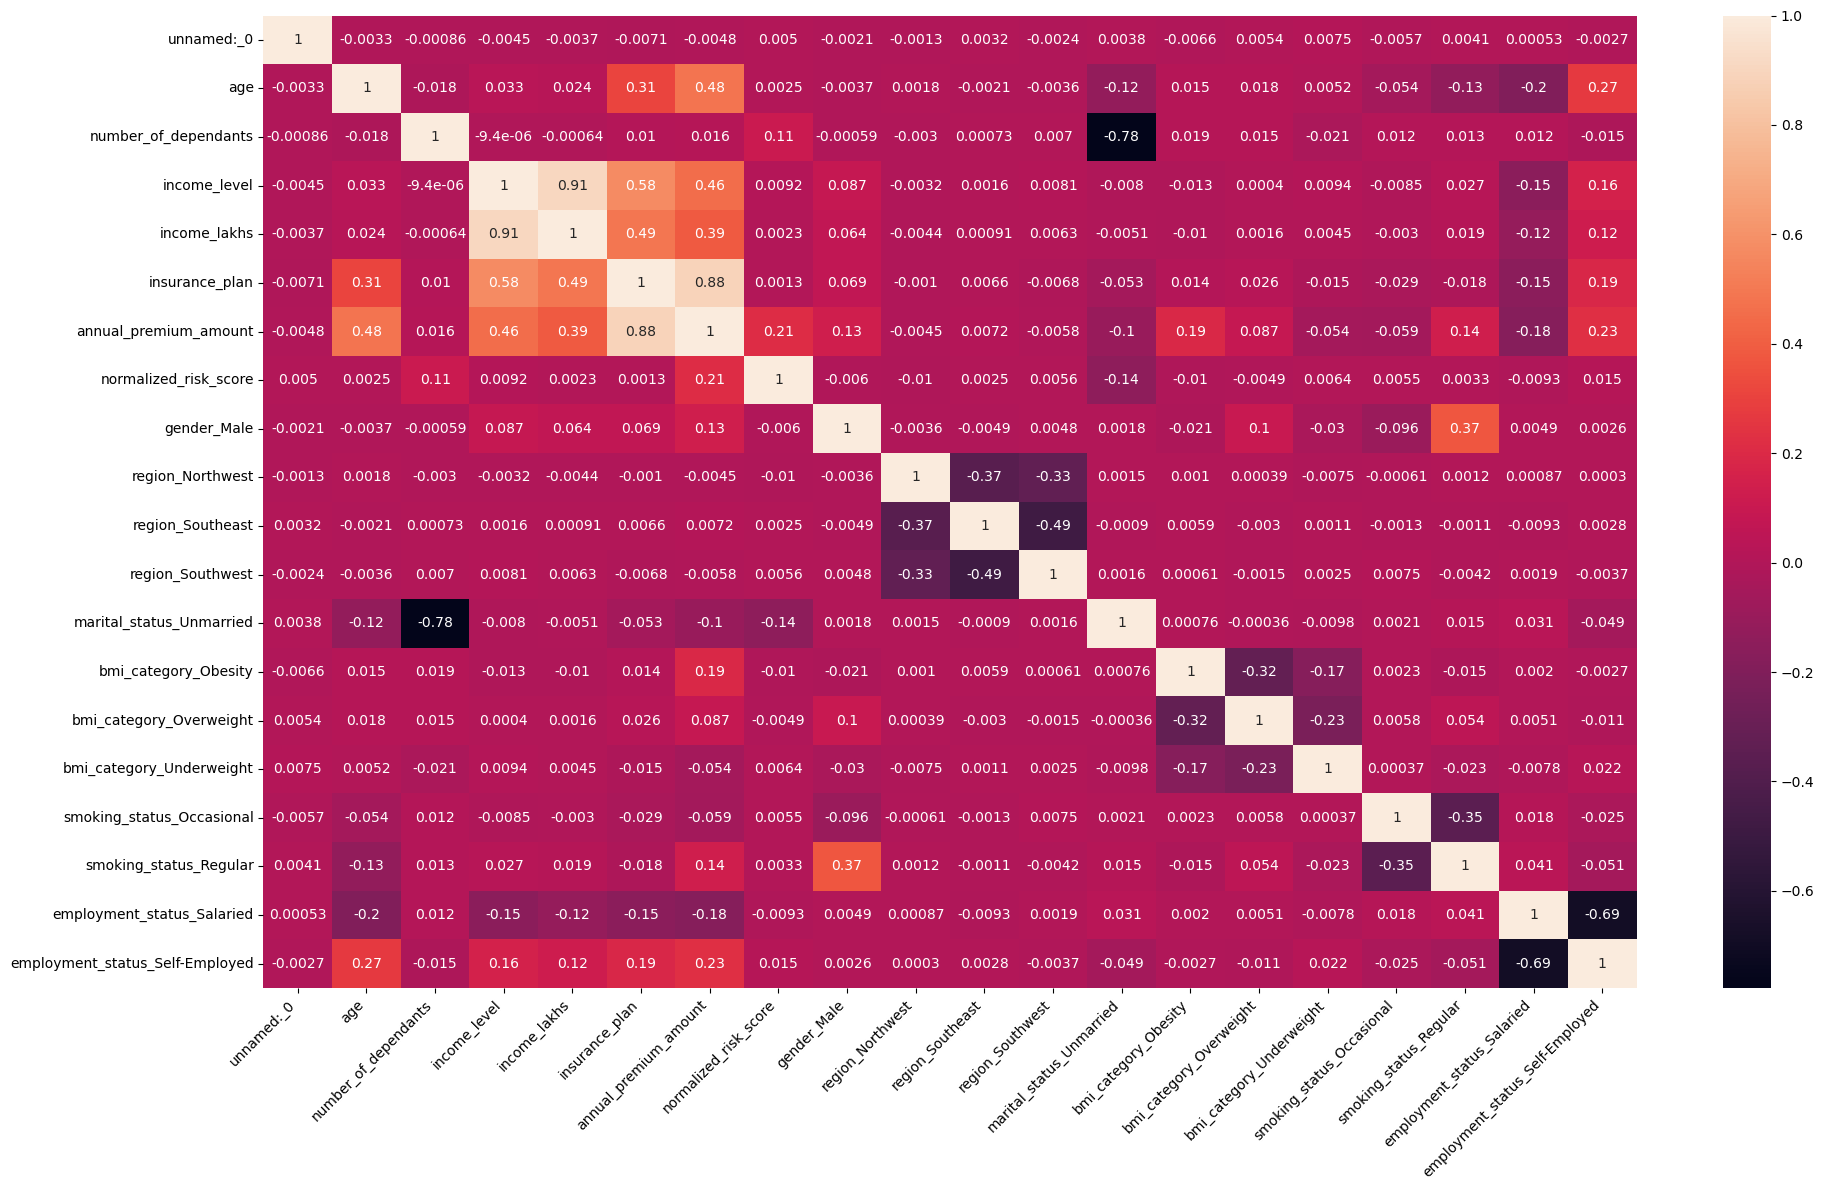

In [55]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [56]:
df4.head(3)

,unnamed:_0,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1


In [57]:
X = df4.drop('annual_premium_amount', axis=1)
y = df4['annual_premium_amount']

cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,unnamed:_0,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,25030.357152,0.371628,0.477547,0.371225,0.224509,0.544112,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,14431.397026,0.240053,0.284129,0.351111,0.226822,0.379009,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12605.250000,0.173913,0.200000,0.000000,0.060606,0.500000,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25070.000000,0.347826,0.600000,0.333333,0.161616,0.500000,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37565.500000,0.565217,0.600000,0.666667,0.313131,1.000000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,49999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
# Calculating VIF for multicollinearity

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [59]:
calculate_vif(X)

,Column,VIF
0,unnamed:_0,3.708010
1,age,3.957380
2,number_of_dependants,6.574054
3,income_level,13.890759
4,income_lakhs,11.186315
5,insurance_plan,5.272795
6,normalized_risk_score,3.847203
7,gender_Male,2.600903
8,region_Northwest,2.143527
9,region_Southeast,3.016241


In [60]:
calculate_vif(X.drop('income_level', axis=1))

,Column,VIF
0,unnamed:_0,3.707947
1,age,3.898275
2,number_of_dependants,6.573384
3,income_lakhs,2.679612
4,insurance_plan,4.576402
5,normalized_risk_score,3.845003
6,gender_Male,2.593274
7,region_Northwest,2.142869
8,region_Southeast,3.015344
9,region_Southwest,2.736554


In [61]:
# We will drop income_level due to high VIF

X_reduced = X.drop('income_level', axis=1)

## 4. Model Training

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (20875, 18)
X_test: (8947, 18)
y_train: (20875,)
y_test: (8947,)


In [63]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
print(f'Train score: {train_score}, Test score: {test_score}')

Train score: 0.9530829689507395, Test score: 0.9546108010185229


In [64]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  2183846.3445353634 RMSE:  1477.7842686046442


In [65]:
model_lr.coef_

array([ 5.68125942e-04,  7.01437541e+03, -1.24806924e+03, -7.48893935e+02,
        1.48403870e+04,  6.02895991e+03,  4.29054782e+01, -7.62176740e+01,
       -2.52153859e+01, -5.32997476e+01, -7.02295766e+02,  3.93051669e+03,
        1.99888191e+03,  5.98181993e+02,  8.55277305e+02,  2.81680024e+03,
       -7.33831069e+01,  2.48787850e+02])

In [66]:
model_lr.intercept_

np.float64(5909.772009348471)

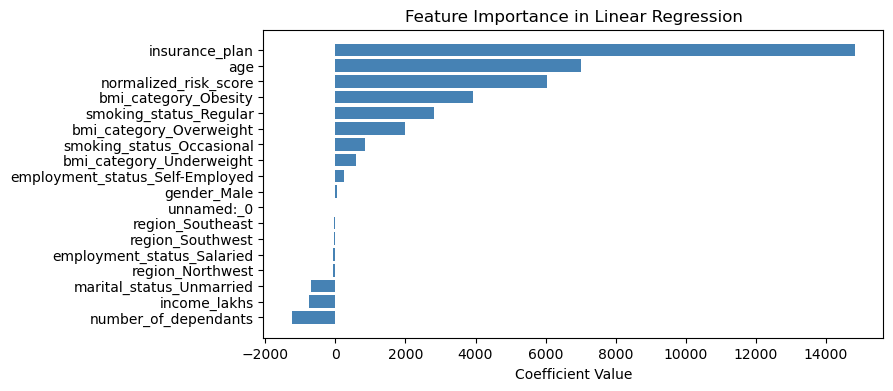

In [67]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regression Model

In [68]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
print(f'Train score: {train_score}, Test score: {test_score}')

Train score: 0.9530828007056761, Test score: 0.9546114175694009


In [69]:
y_pred = model_rg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  2183816.6799364854 RMSE:  1477.7742317202874


### XGBoost

In [70]:
model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.9950187802314758

In [71]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  239665.8125 RMSE:  489.5567510513975


In [72]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.9970053235689799)

In [73]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [74]:
best_model = random_search.best_estimator_

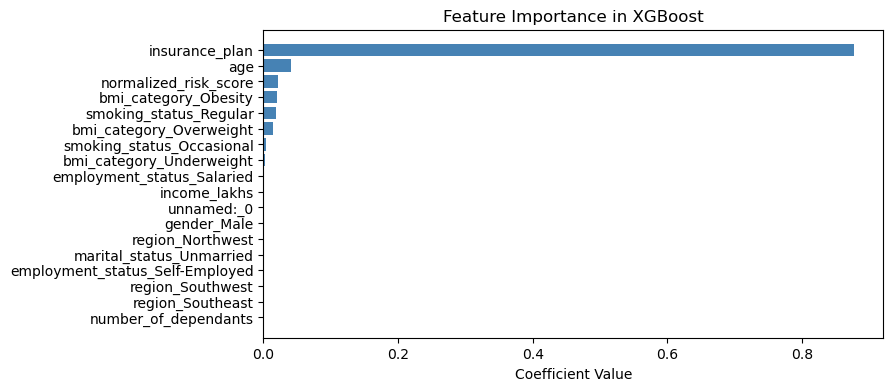

In [75]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

### Error Analysis

In [76]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'difference': residuals,
    'difference_pct': residuals_pct
})
results_df.head()

,actual,predicted,difference,difference_pct
5495,30838,31168.617188,330.617188,1.072110
582,26306,26138.771484,-167.228516,-0.635705
281,17983,17611.267578,-371.732422,-2.067132
15443,19345,18925.273438,-419.726562,-2.169690
24281,33317,33256.781250,-60.218750,-0.180745


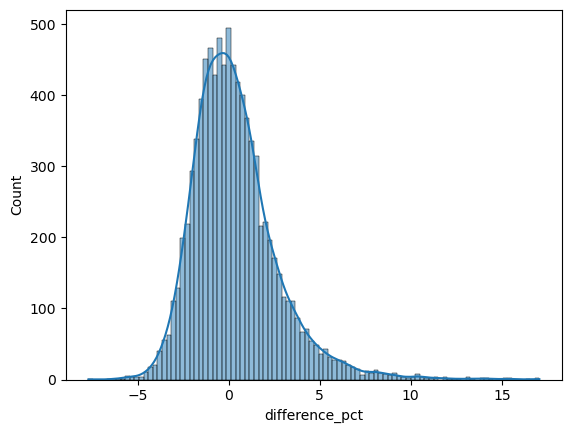

In [77]:
sns.histplot(results_df['difference_pct'], kde=True)
plt.show()

In [78]:
# Setting a threshold in residuals

extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df['difference_pct']) > extreme_error_threshold]
extreme_results_df.shape

(45, 4)

In [79]:
results_df.shape

(8947, 4)

In [80]:
extreme_errors_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_errors_pct

0.5029618866659216

In [81]:
results_df[np.abs(results_df['difference_pct']) > 50].sort_values('difference_pct', ascending=False)

,actual,predicted,difference,difference_pct


* The percentage of error margins are quite high because of which we cannot deploy this model.
* We need to analyze more to understand why are we getting such a high percentage of margin errors.

In [82]:
# Finding the records from test data having high margin errors

extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,unnamed:_0,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
17866,29941,0.152174,0.6,0.060606,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0
252,403,0.065217,0.6,0.020202,0.0,0.0,1,0,1,0,0,0,0,0,1,0,0,0
11864,19887,0.043478,0.2,0.020202,0.0,0.0,1,0,0,1,1,0,0,0,0,0,1,0
16263,27277,0.673913,0.6,0.383838,0.0,0.0,1,1,0,0,0,0,0,0,0,0,0,0
28595,47772,0.217391,0.0,0.303030,0.0,0.0,0,0,0,1,1,0,0,0,1,0,0,1


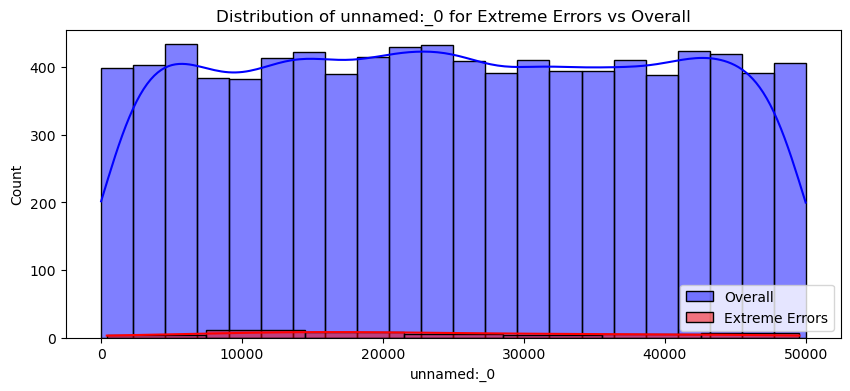

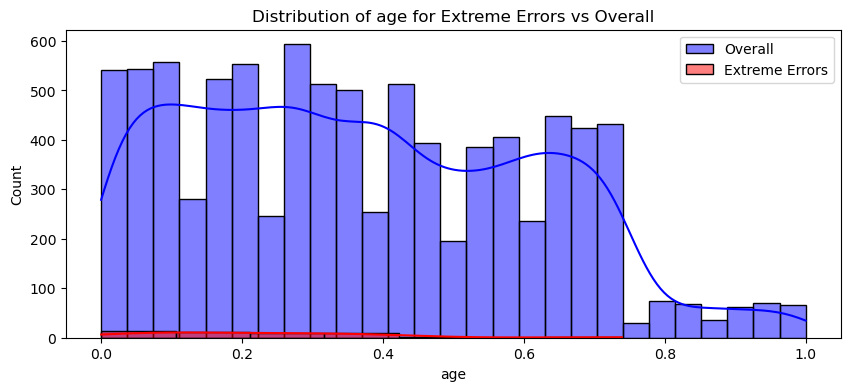

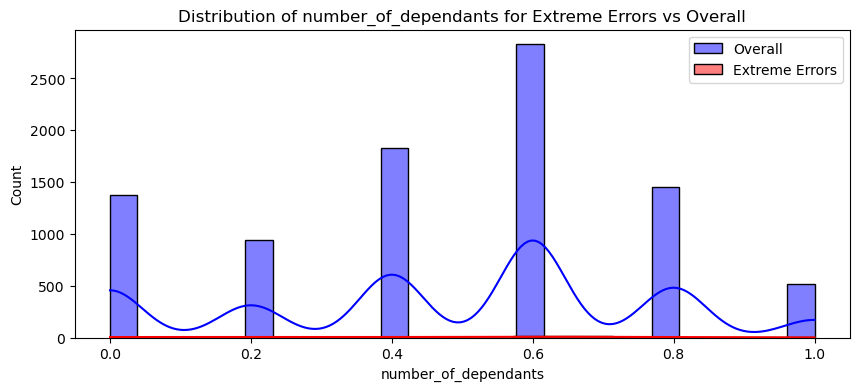

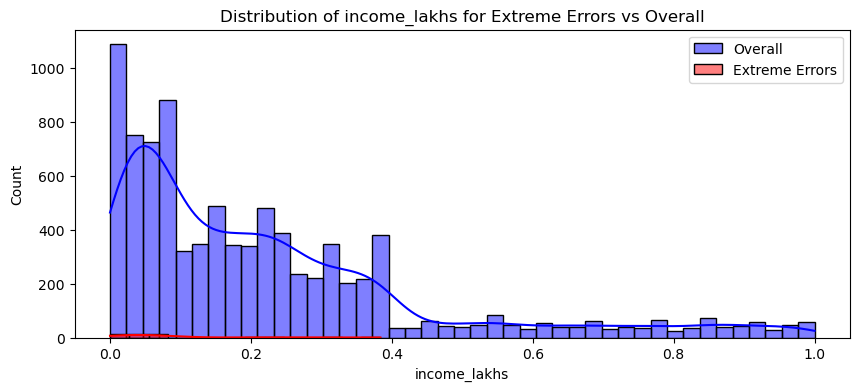

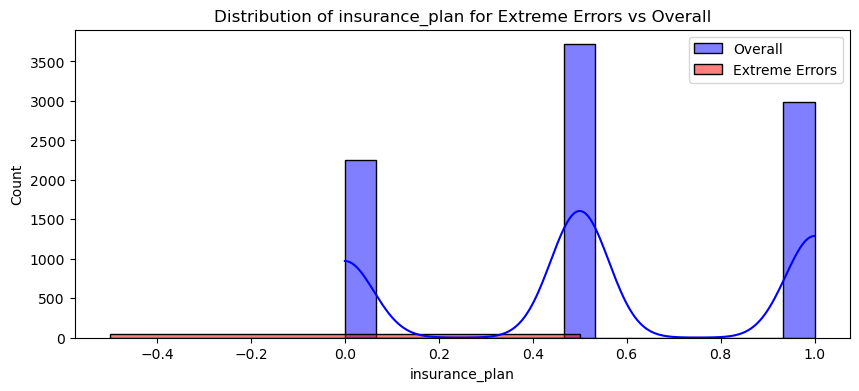

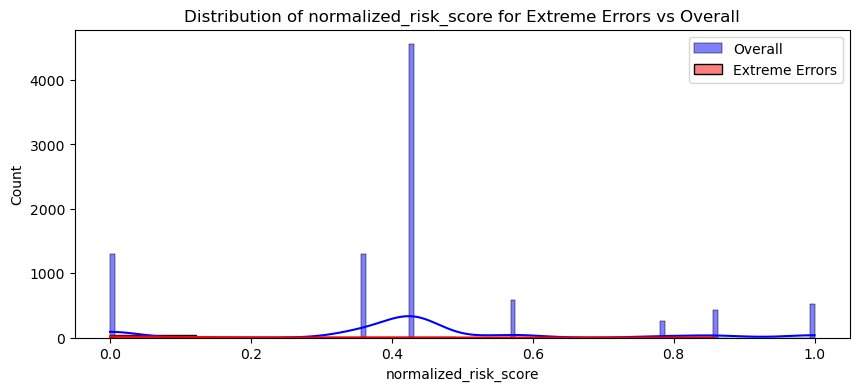

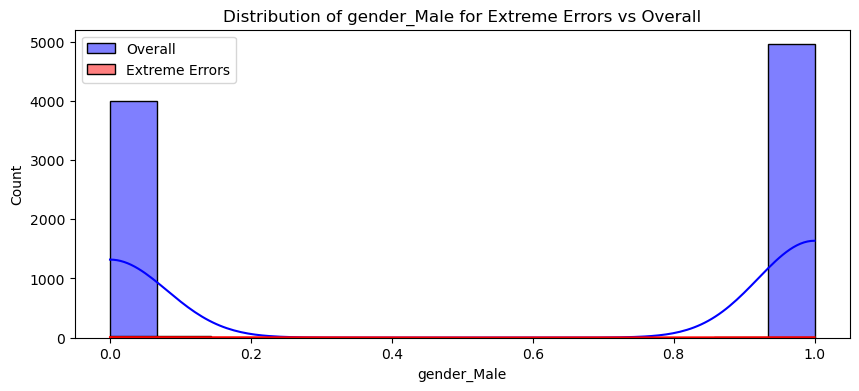

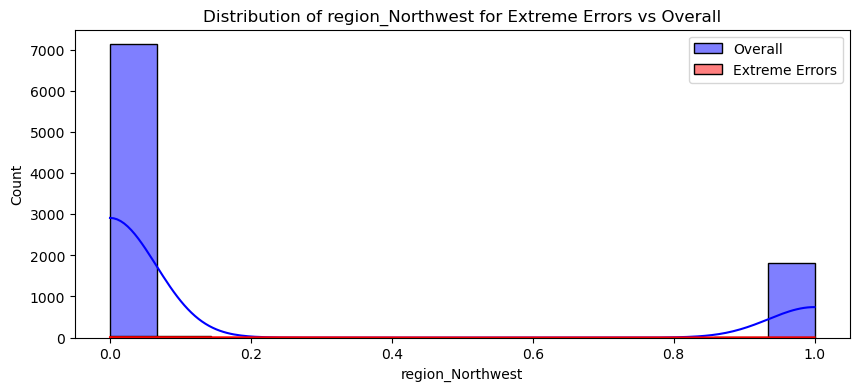

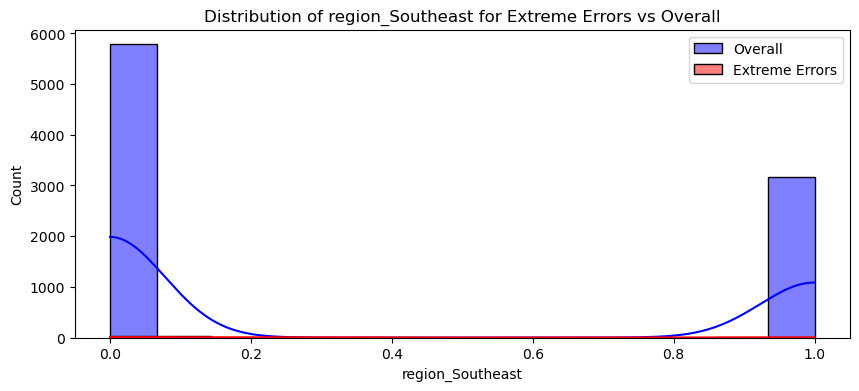

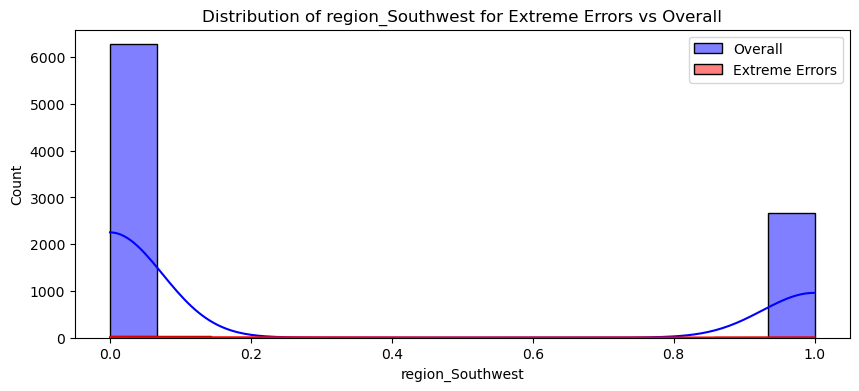

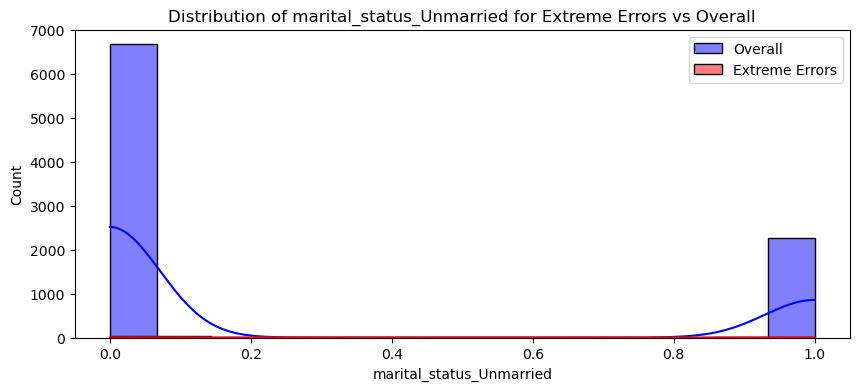

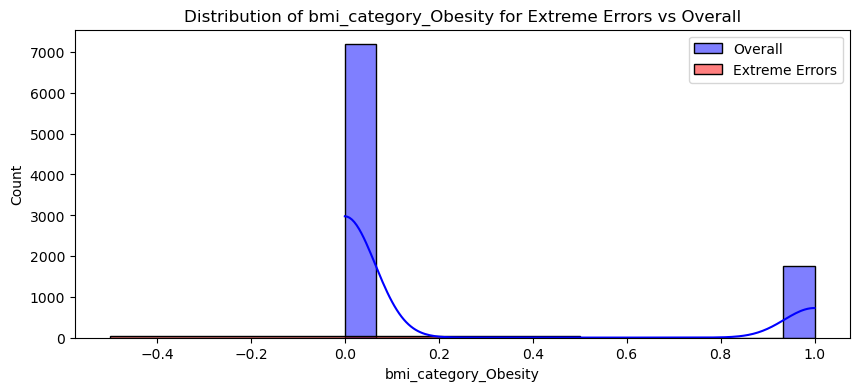

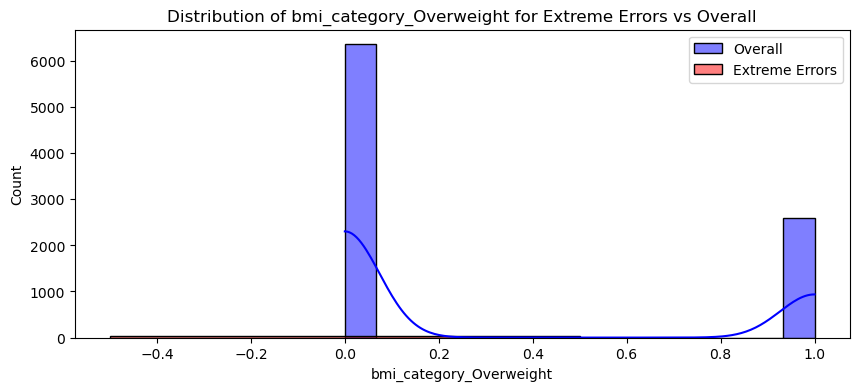

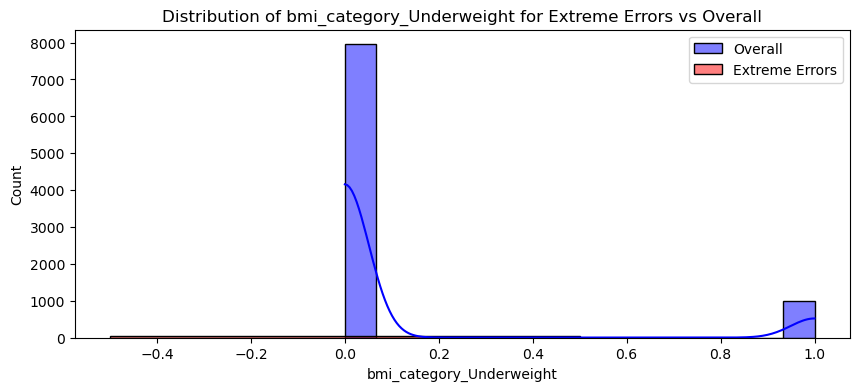

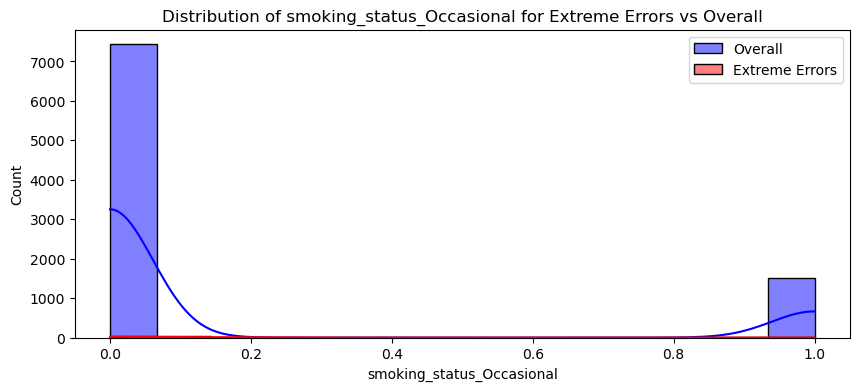

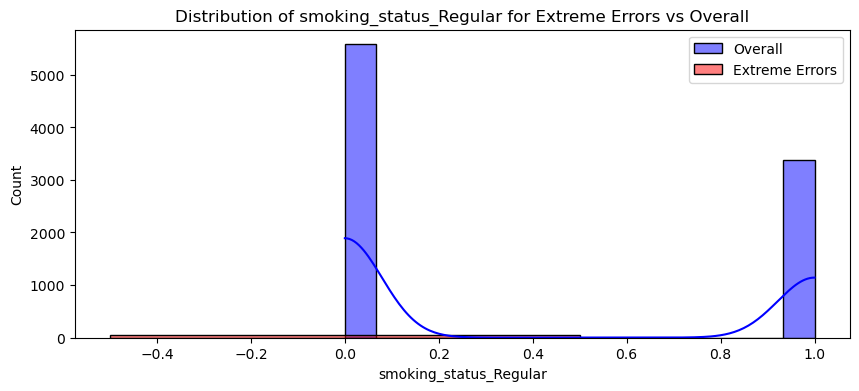

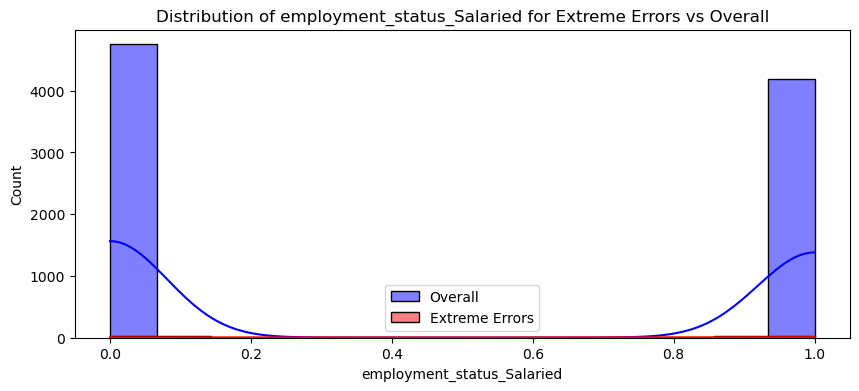

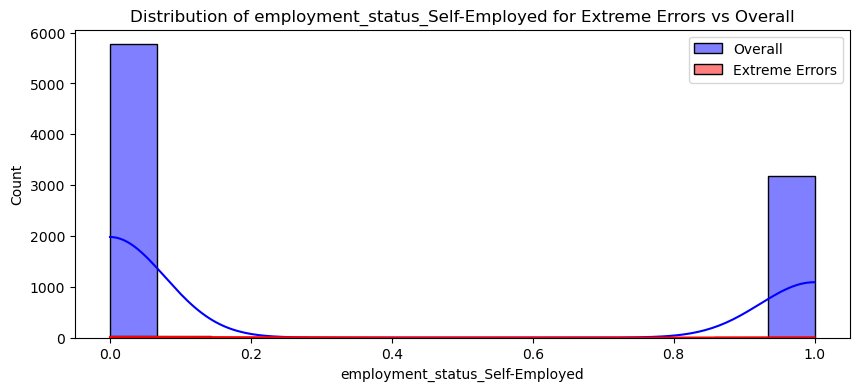

In [83]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.legend()
    plt.show()

* We can observe that there are some extreme errors in lower age group.
* We will do reverse sclaing to understand which age groups are showing such a high margin of errors.

In [84]:
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [85]:
extreme_errors_df.columns

Index(['unnamed:_0', 'age', 'number_of_dependants', 'income_lakhs',
       'insurance_plan', 'normalized_risk_score', 'gender_Male',
       'region_Northwest', 'region_Southeast', 'region_Southwest',
       'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

In [86]:
extreme_errors_df['income_level'] = -1 # adding column back again as it was removed because of high VIF
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] =  scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,33.0,3.0,-2.0,7.0,1.0
1,29.0,3.0,-2.0,3.0,1.0
2,28.0,1.0,-2.0,3.0,1.0
3,57.0,3.0,-2.0,39.0,1.0
4,36.0,0.0,-2.0,31.0,1.0
5,27.0,3.0,-2.0,6.0,1.0
6,44.0,3.0,-2.0,7.0,1.0
7,43.0,1.0,-2.0,5.0,1.0
8,26.0,1.0,-2.0,7.0,1.0
9,41.0,1.0,-2.0,6.0,1.0


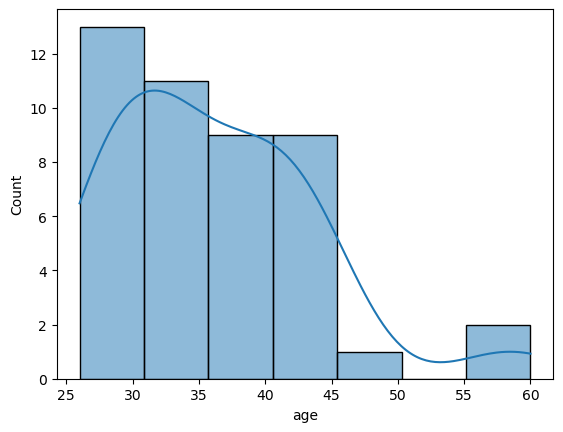

In [87]:
# Visual representation of age group

sns.histplot(df_reversed.age, kde=True)
plt.show()

In [88]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,45.000000,45.000000,45.0,45.000000,45.0
mean,36.200000,2.088889,-2.0,7.688889,1.0
std,7.641394,1.474360,0.0,7.908058,0.0
min,26.000000,0.000000,-2.0,1.000000,1.0
25%,30.000000,1.000000,-2.0,3.000000,1.0
50%,35.000000,3.000000,-2.0,6.000000,1.0
75%,41.000000,3.000000,-2.0,8.000000,1.0
max,60.000000,5.000000,-2.0,39.000000,1.0


In [89]:
df_reversed['age'].quantile(0.97)

np.float64(53.48)

* 97% of the records in extreme errors data frame have age groups less than 25.